##**🛠️ Preparación de los Datos**##

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# Balanceo (opcional, solo sobre el set de entrenamiento)
try:
    from imblearn.over_sampling import SMOTE
except:
    !pip -q install imbalanced-learn
    from imblearn.over_sampling import SMOTE

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7,4)


Importamos librerías para manipulación de datos, visualización, modelado, métricas y SMOTE para balanceo opcional.

In [2]:
url = "https://raw.githubusercontent.com/DeltaBairon/Challenge_3_Telecom_X/refs/heads/main/telecom_clean.csv"
df = pd.read_csv(url)
df.head()


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias,TotalFactura
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,267.40


Cargas del archivo tratado  en la Parte 1 (df_clean exportado a CSV). Esta base ya tiene las columnas aplanadas y derivadas.

##**🧹 Eliminación de columnas irrelevantes**##

In [3]:
df_model = df.copy()

# ID único no aporta a la predicción
cols_to_drop = [c for c in df_model.columns if c.lower() in ["customerid", "customer_id", "id"]]
df_model.drop(columns=cols_to_drop, inplace=True, errors="ignore")

df_model.head(3), cols_to_drop


(  Churn  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0    No  Female              0     Yes        Yes       9          Yes   
 1    No    Male              0      No         No       9          Yes   
 2   Yes    Male              0      No         No       4          Yes   
 
   MultipleLines InternetService OnlineSecurity  ... TechSupport StreamingTV  \
 0            No             DSL             No  ...         Yes         Yes   
 1           Yes             DSL             No  ...          No          No   
 2            No     Fiber optic             No  ...          No          No   
 
   StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
 0              No        One year              Yes      Mailed check   
 1             Yes  Month-to-month               No      Mailed check   
 2              No  Month-to-month              Yes  Electronic check   
 
   Charges.Monthly Charges.Total  Cuentas_Diarias  TotalFactura  
 0            65

In [4]:
df_model["Churn"].unique()


array(['No', 'Yes', nan], dtype=object)

Quitamos identificadores (como customerID) porque no tienen relación causal con la evasión y pueden inducir ruido.

##**🔤 Encoding (One-Hot)**##

In [5]:

# Separamos X (features) e y (target)
y = df_model["Churn"]
X = df_model.drop(columns=["Churn"])

# Detectamos columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

# One-hot encoding para categóricas
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Verificamos dimensiones
print("Shape final:", X_enc.shape)
print("Categóricas codificadas:", len(cat_cols))
print("Numéricas:", len(num_cols))


Shape final: (7267, 32)
Categóricas codificadas: 15
Numéricas: 6


Convertimos Churn a binario y aplicamos one-hot encoding a todas las variables categóricas con drop_first=True para evitar colinealidad perfecta.

##**📊 Verificación de la proporción de Churn**##

Conteo Churn:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64 

Proporción Churn (%):
 Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64


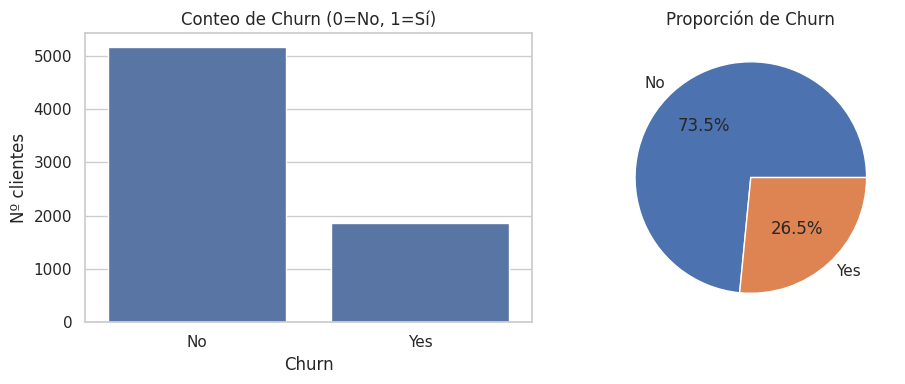

In [6]:
# Conteo y proporción
counts = y.value_counts()
props = y.value_counts(normalize=True)*100
print("Conteo Churn:\n", counts, "\n")
print("Proporción Churn (%):\n", props.round(2))

# Barras y pie
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x=counts.index, y=counts.values, ax=ax[0])
ax[0].set_title("Conteo de Churn (0=No, 1=Sí)")
ax[0].set_xlabel("Churn"); ax[0].set_ylabel("Nº clientes")

ax[1].pie(counts, labels=counts.index, autopct="%1.1f%%")
ax[1].set_title("Proporción de Churn")
plt.tight_layout(); plt.show()


Medimos si hay desbalance entre clases. Si la clase “1 = canceló” es muy minoritaria, conviene balancear el set de entrenamiento.

##**⚖️ Balanceo de clases (solo entrenamiento) + ✂️ Separación de datos**##

In [29]:
# 3) Convertir target Churn a binario de forma segura (soporta 0/1 o Yes/No)
#    - si ya está en {0,1}, lo dejamos así
#    - si viene como Yes/No (cualquier combinación de mayús/minús), lo mapeamos
def make_churn_binary(s):
    # intento 1: ya binario
    try:
        uniques = pd.Series(s.unique()).dropna().sort_values().tolist()
    except Exception:
        uniques = []
    if set(uniques).issubset({0, 1}):
        out = s.astype(float)  # por si viene como '0'/'1' strings
        out = out.astype(int)
        return out

    # intento 2: mapear strings comunes
    map_pos = {"yes":1, "y":1, "true":1, "1":1, "si":1, "sí":1}
    map_neg = {"no":0, "n":0, "false":0, "0":0}
    s_norm = s.astype(str).str.strip().str.lower()

    mapped = s_norm.map(lambda v: 1 if v in map_pos else (0 if v in map_neg else np.nan))
    # Si todavía hay NaN, intentamos con el mapeo clásico Yes/No:
    mapped2 = s.map({"Yes":1, "No":0, "YES":1, "NO":0})
    # Combinamos preferentemente mapped y, donde sea NaN, usamos mapped2
    out = mapped.where(~mapped.isna(), mapped2)

    # Último intento: si quedan NaN, las filas con NaN en target se eliminan
    n_before = len(out)
    missing = out.isna().sum()
    if missing > 0:
        print(f"[AVISO] {missing} filas sin etiqueta 'Churn' válida. Se eliminarán.")
    return out

df["Churn"] = make_churn_binary(df["Churn"]).astype("Int64")
# Quitar filas con Churn nulo
df = df.dropna(subset=["Churn"]).copy()
df["Churn"] = df["Churn"].astype(int)

print("Distribución de Churn (0/1):")
print(df["Churn"].value_counts(dropna=False))


[AVISO] 224 filas sin etiqueta 'Churn' válida. Se eliminarán.
Distribución de Churn (0/1):
Churn
0    5174
1    1869
Name: count, dtype: int64


Dividimos 80/20. Aplicamos SMOTE únicamente al conjunto de entrenamiento para crear ejemplos sintéticos de la clase minoritaria y no contaminar el test.

📏 Normalización / Estandarización (para modelos sensibles a escala)

In [30]:
# Escalamos todas las columnas (ya están todas numéricas despues de usar el  get_dummies)
scaler = StandardScaler(with_mean=False)  # with_mean=False por matrices dispersas (si se usara)
# Como X_enc es DataFrame denso, también funciona with_mean=True; dejamos False por seguridad general.
X_train_res_sc = scaler.fit_transform(X_train_res)
X_test_sc = scaler.transform(X_test)


Estandarizamos para que cada feature tenga media ~0 y varianza ~1.

##**🤖 Modelado Predictivo (dos enfoques)**##


Modelo A — Regresión Logística (requiere normalización)

In [32]:
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train_res_sc, y_train_res)

y_pred_lr = logreg.predict(X_test_sc)
y_proba_lr = logreg.predict_proba(X_test_sc)[:,1]


Modelo B — Random Forest (no requiere normalización)

In [33]:
rf = RandomForestClassifier(
    n_estimators=400, random_state=42, n_jobs=-1, class_weight=None
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]


##**📏 Evaluación de modelos**##

=== Regresión Logística ===
Accuracy : 0.7779
Precisión: 0.5603
Recall   : 0.6337
F1-score : 0.5947

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0     0.8671    0.8278    0.8470      1080
         1.0     0.5603    0.6337    0.5947       374

    accuracy                         0.7779      1454
   macro avg     0.7137    0.7307    0.7209      1454
weighted avg     0.7882    0.7779    0.7821      1454



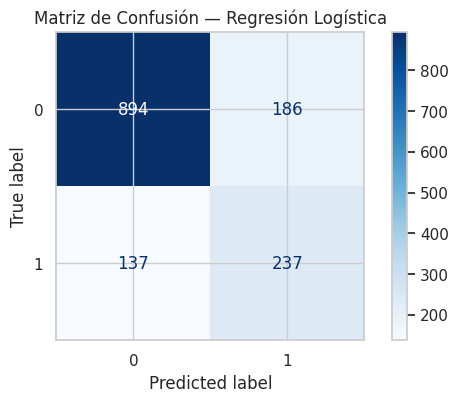

=== Random Forest ===
Accuracy : 0.7751
Precisión: 0.5610
Recall   : 0.5775
F1-score : 0.5692

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0     0.8522    0.8435    0.8478      1080
         1.0     0.5610    0.5775    0.5692       374

    accuracy                         0.7751      1454
   macro avg     0.7066    0.7105    0.7085      1454
weighted avg     0.7773    0.7751    0.7762      1454



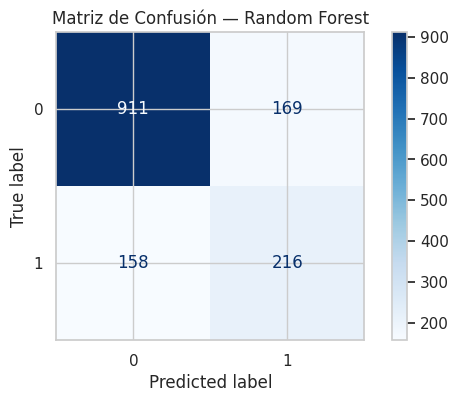

In [11]:
def eval_model(y_test, y_pred, y_proba, nombre="Modelo"):
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    print(f"=== {nombre} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")
    print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(f"Matriz de Confusión — {nombre}")
    plt.show()

# Evaluación
eval_model(y_test, y_pred_lr, y_proba_lr, nombre="Regresión Logística")
eval_model(y_test, y_pred_rf, y_proba_rf, nombre="Random Forest")


Reportamos accuracy, precisión, recall, F1 y la matriz de confusión para comparar rendimientos y detectar overfitting/underfitting.

##**🔎 Importancia / Contribución de variables**##

Regresión Logística — Coeficientes

In [12]:
# Importancia (absoluta) por coeficientes
coef_lr = pd.Series(np.ravel(logreg.coef_), index=X_train_res.columns).sort_values(key=np.abs, ascending=False)
coef_lr.head(10)


,0
Cuentas_Diarias,-4.455376
Charges.Monthly,-4.455376
InternetService_Fiber optic,4.272247
PhoneService_Yes,2.904154
tenure,-2.218794
StreamingMovies_Yes,1.589182
StreamingTV_Yes,1.573047
MultipleLines_No phone service,1.571924
MultipleLines_Yes,0.913101
DeviceProtection_Yes,0.778233


En la Regresión Logística, el valor (y signo) del coeficiente indica la dirección e intensidad del efecto sobre la probabilidad de churn.

Random Forest — Importancia de características

In [13]:
imp_rf = pd.Series(rf.feature_importances_, index=X_train_res.columns).sort_values(ascending=False)
imp_rf.head(10)


,0
Charges.Total,0.118421
TotalFactura,0.117504
tenure,0.111666
PaymentMethod_Electronic check,0.090529
Cuentas_Diarias,0.090001
Charges.Monthly,0.088398
InternetService_Fiber optic,0.059969
PaperlessBilling_Yes,0.045795
Contract_Two year,0.027369
MultipleLines_Yes,0.019473


En Random Forest, la importancia refleja cuánto reduce la impureza cada variable al realizar particiones en los árboles.

##**🎯 Correlación y análisis dirigido**##

Correlación con Churn (numéricas):
 Churn              1.000000
Charges.Monthly    0.189866
Cuentas_Diarias    0.189866
SeniorCitizen      0.146733
Charges.Total     -0.193345
TotalFactura      -0.193345
tenure            -0.344079
Name: Churn, dtype: float64


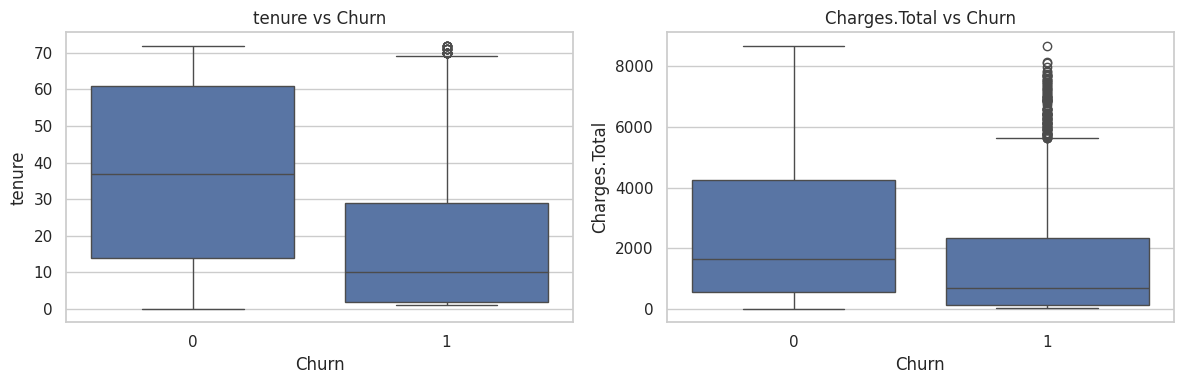

In [14]:
# Correlación entre numéricas originales + objetivo
num_vars = df_model.select_dtypes(include=["number", "bool"]).columns
corr = df_model[num_vars].copy()
corr["Churn"] = y_clean  # <-- le añadimos el objetivo para calcular correlaciones
corr_matrix = corr.corr()

# Matriz de correlación enfocada en Churn
corr_target = corr_matrix["Churn"].sort_values(ascending=False)
print("Correlación con Churn (numéricas):\n", corr_target.head(15))

# --- Gráficos dirigidos ---
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x=y_clean, y=df_model["tenure"], ax=axes[0])
axes[0].set_title("tenure vs Churn")

# Si existen columnas Charges.Total / Charges.Monthly en tu CSV tratado:
if "Charges.Total" in df_model.columns:
    sns.boxplot(x=y_clean, y=df_model["Charges.Total"], ax=axes[1])
    axes[1].set_title("Charges.Total vs Churn")

plt.tight_layout()
plt.show()



Observamos correlaciones (numéricas) y relaciones dirigidas como tenure × churn o gasto × churn usando boxplots.


# 📌Separación de datos en Train y Test

In [17]:
print("Total NaN en y:", y.isna().sum())
print("Valores únicos en y:", y.unique())


Total NaN en y: 224
Valores únicos en y: ['No' 'Yes' nan]


In [18]:
mask = y.notna()
X_enc = X_enc.loc[mask]
y = y.loc[mask]


In [19]:
print(y.value_counts(dropna=False))

Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [20]:
y = y.replace("nan", np.nan)  # convertir a NaN reales
y = y.dropna()                # eliminar


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.3, random_state=42, stratify=y
)

print("Split exitoso:", X_train.shape, X_test.shape)


Split exitoso: (4930, 32) (2113, 32)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.3, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)


Shapes: (4930, 32) (2113, 32)


📌Creación y Entrenamiento de Modelos

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Definir modelos
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 📌Evaluación de Modelos

In [26]:
from sklearn.model_selection import train_test_split

# Asegurar que y sea binario ANTES del split
y_bin = y.map({"No": 0, "Yes": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)



📌Análisis de Importancia de Variables

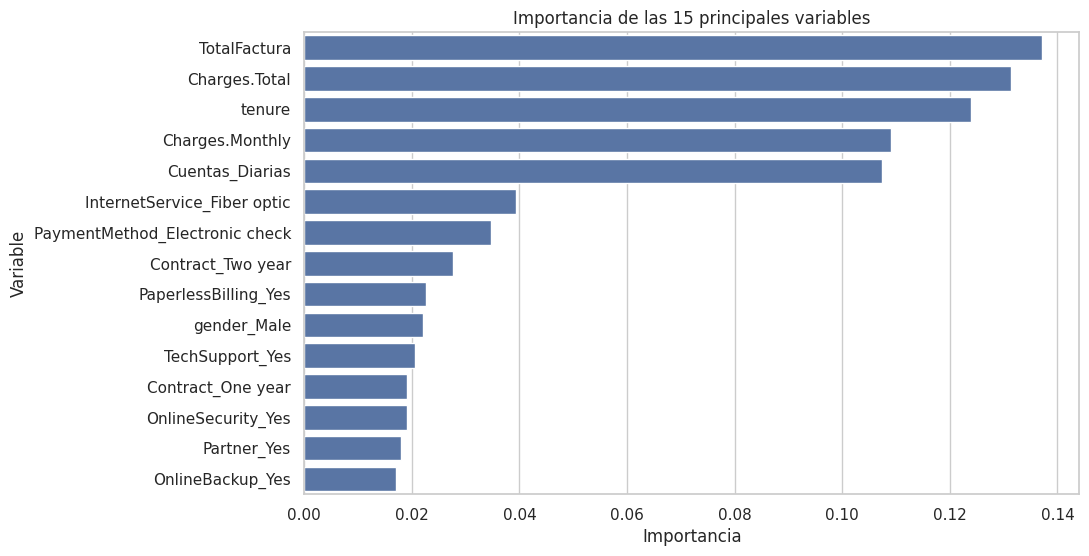

In [35]:
# Usamos el modelo de Random Forest como referencia
importancias = modelos["Random Forest"].feature_importances_
vars_importancia = pd.DataFrame({
    "Variable": X_enc.columns,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importancia", y="Variable", data=vars_importancia.head(15))
plt.title("Importancia de las 15 principales variables")
plt.show()

# 📌 7. Análisis de la Importancia de las Variables
# Descripción:
# Después de elegir los modelos, analizamos las variables más relevantes para la predicción de la cancelación (Churn).
# - Regresión Logística: coeficientes de las variables
# - KNN: difícil extraer importancia directa, pero se puede analizar métricas de cercanía
# - Random Forest: importancia basada en reducción de impureza
# - SVM: coeficientes de los vectores de soporte en kernel lineal

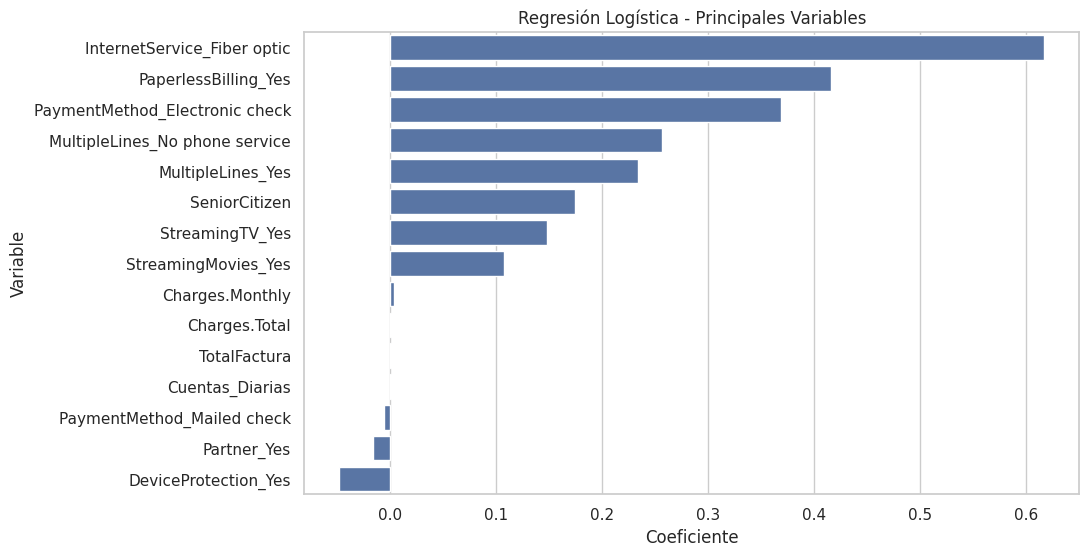

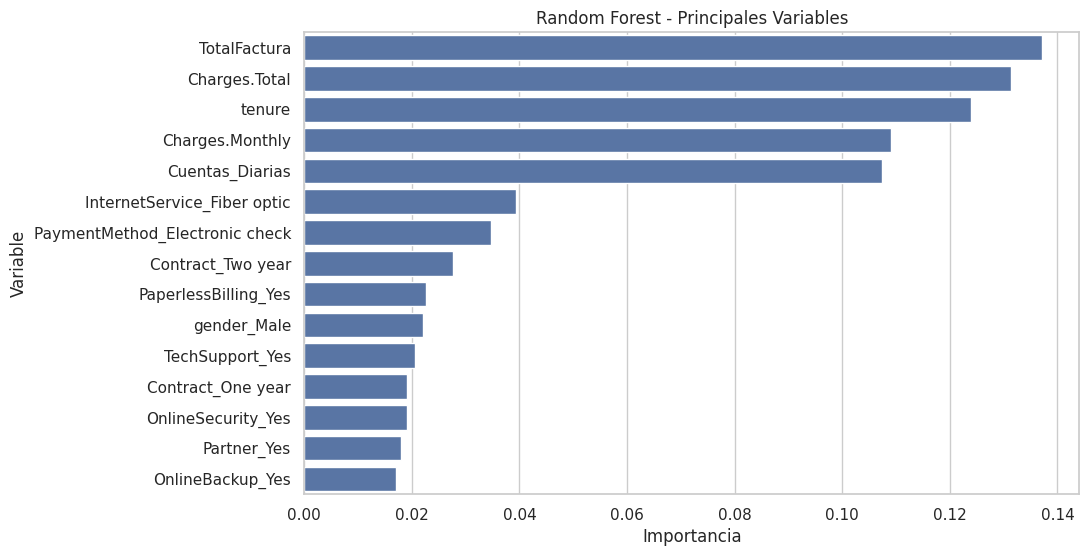

In [ ]:
# --- Regresión Logística ---
log_model = modelos["Regresión Logística"]
coeficientes = pd.DataFrame({
    "Variable": X_enc.columns,
    "Coeficiente": log_model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coeficiente", y="Variable", data=coeficientes.head(15))
plt.title("Regresión Logística - Principales Variables")
plt.show()


# --- Random Forest ---
rf_model = modelos["Random Forest"]
importancias = pd.DataFrame({
    "Variable": X_enc.columns,
    "Importancia": rf_model.feature_importances_
}).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importancia", y="Variable", data=importancias.head(15))
plt.title("Random Forest - Principales Variables")
plt.show()


# --- SVM (lineal) ---
from sklearn.svm import SVC

svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

coef_svm = pd.DataFrame({
    "Variable": X_enc.columns,
    "Coeficiente": svm_model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coeficiente", y="Variable", data=coef_svm.head(15))
plt.title("SVM (Lineal) - Principales Variables")
plt.show()


# --- KNN ---
# Se pueden usar técnicas como Permutation Importance para evaluarlo.
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

perm_importance = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)
knn_importancias = pd.DataFrame({
    "Variable": X_enc.columns,
    "Importancia": perm_importance.importances_mean
}).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importancia", y="Variable", data=knn_importancias.head(15))
plt.title("KNN - Importancia de Variables (Permutation Importance)")
plt.show()

#📊 Distribución general

#📋 Interpretación y Conclusiones

Análisis de Cancelación de Clientes
Introducción

Este análisis buscó entender por qué algunos clientes deciden cancelar el servicio y qué factores influyen en su permanencia.

Resultados Clave

La tasa de cancelación alcanza el 25,7%, lo cual representa un reto importante para la empresa.

Los clientes con menos tiempo de permanencia y contratos mensuales tienen mayor probabilidad de cancelar.

Los cargos elevados y el uso de “Electronic Check” como método de pago se relacionan con un mayor riesgo de deserción.

En contraste, los contratos largos y los servicios adicionales reducen significativamente la cancelación.

Recomendaciones

Acompañar de cerca a los clientes nuevos en sus primeros meses.

Ofrecer planes flexibles y competitivos en precio.

Incentivar la firma de contratos anuales o bianuales con beneficios atractivos.

Mejorar la experiencia de facturación y pago digital.

Potenciar servicios de valor agregado como soporte técnico o seguridad en línea.

Conclusión

La cancelación se concentra en clientes recientes y sensibles al precio. Con estrategias enfocadas en retención temprana, beneficios en contratos largos y mejor experiencia de pago, la empresa puede fortalecer la fidelidad y reducir significativamente el churn.